# Watermark Detection

Types of watermarks in images:
1. **Text Watermarks**: These are the most common type. They usually contain the name of the photographer, artist, or company that owns the image. Text watermarks can vary in size, color, and placement to either be discreet or more noticeable.

2. **Logo Watermarks**: Instead of text, some prefer using a logo or symbol that represents their brand or identity. These are particularly common for companies or professional photographers.

3. **Tile Watermarks**: These cover the entire image with a repeated pattern of text or logo. They are designed to be very difficult to remove without damaging the underlying image.

Properties of watermarks:

1. **Color**: The color of the watermark can be chosen to contrast with the image, making it more visible, or to blend in, making it less obtrusive. Common choices are black, white, or shades of gray, but any color can be used.

2. **Opacity**: The transparency level of the watermark is crucial. A more transparent (or lower opacity) watermark is less noticeable, while a less transparent (or higher opacity) one is more prominent.

3. **Size**: Watermarks can range from small and discreet to large and covering a significant part of the image. The size often depends on how noticeable the owner wants the watermark to be.

4. **Font**: The choice of font can greatly affect the appearance of text watermarks. Fonts can range from simple and professional to artistic and decorative.

5. **Position**: The placement of the watermark on the image is important. Common positions include corners, the center, or along the edges. Some choose to place the watermark in a spot that is hard to remove without damaging the image.

6. **Rotation and Alignment**: Watermarks can be aligned horizontally, vertically, or even diagonally. The rotation and alignment can affect how the watermark interacts with the image.

7. **Pattern (for tiled watermarks)**: If a tiled watermark is used, the pattern and frequency of the tile can be adjusted. This type of watermark repeats across the image.

Characteristics of datasets:
1. Single and multi watermarked images
2. Overlapping and non-overlapping watermarks
3. Non aligned bounding boxes (4 coordinates)
4. 256x256 images
5. 100k base images in total from image-net (all classes)
6. Logos from this dataset: https://hangsu0730.github.io/qmul-openlogo/

In [399]:
# read all images in data/

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# load all images
data = []
for filename in os.listdir(os.path.join("data", "pictures")):
    img = Image.open(os.path.join("data", "pictures", filename))
    data.append(img)

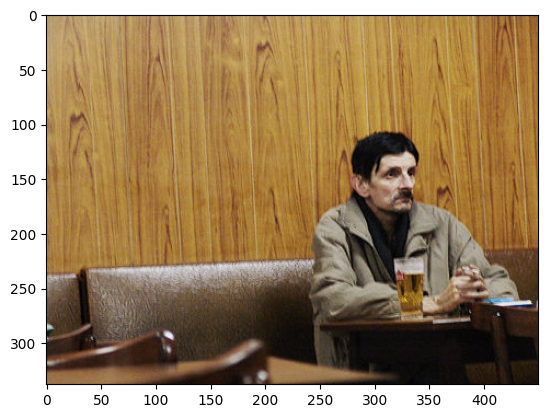

In [400]:
from matplotlib import pyplot as plt
import numpy as np

test_img = data[4]

plt.imshow(test_img)
plt.show()

In [401]:
import matplotlib.font_manager

flist = matplotlib.font_manager.findSystemFonts()
names = [matplotlib.font_manager.FontProperties(fname=fname).get_file().split("\\")[-1].lower() for fname in flist]
print(len(names))
for name in names[::]:
    try:
        font = ImageFont.truetype(name)
    except:
        names.remove(name)
len(names)

344


121

In [402]:
# import all the libraries
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import matplotlib.pyplot as plt
import numpy as np

def add_text_watermark(img, txt, position, color, fontname, orientation, size):
    # text Watermark
    new_img = img.copy().convert('RGBA')
    txt_new_img = Image.new('RGBA', new_img.size, (255,255,255,0))
    txt_image = Image.new('RGBA', img.size, (255,255,255,0))

    draw = ImageDraw.Draw(txt_image)
    font = ImageFont.truetype(fontname, size)
    draw.text(position, txt, fill=(0, 0, 0, 255), font=font, anchor='ms')
    txt_image = txt_image.rotate(orientation)

    draw = ImageDraw.Draw(txt_new_img)
    draw.text(position, txt, fill=color, font=font, anchor='ms')
    txt_new_img = txt_new_img.rotate(orientation)
    combined = Image.alpha_composite(new_img, txt_new_img)

    # bouding boxes
    bbox = txt_image.getbbox()

    return combined, txt_image, bbox

In [403]:
import random
import string

def generate_random_string(length):
    letters = string.printable
    letters += string.whitespace.replace('\n', '').replace('\t', '')
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

generate_random_string(10)

'\x0b\x0c!\x0cL[u``3'

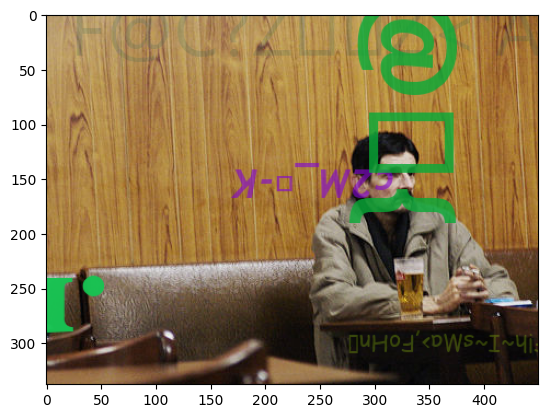

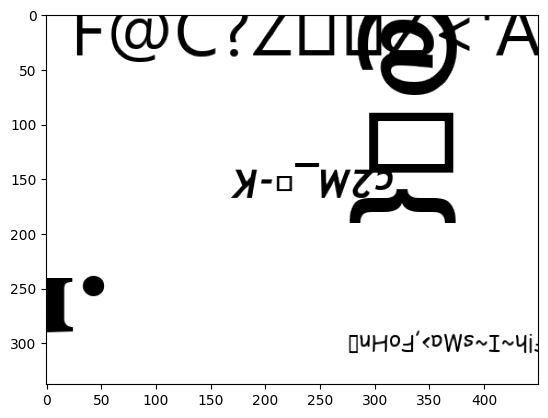

In [404]:
def add_random_text_watermark(img):
    w, h = img.size
    txt = generate_random_string(np.random.randint(1, 25))
    position = (np.random.randint(0, w), np.random.randint(0, h))
    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(15, 255))
    fontname = np.random.choice(names)
    orientation = np.random.choice([0, 90, 180, 270])
    size = np.random.randint(5, min(w, h) // 3)
    return add_text_watermark(img, txt, position, color, fontname, orientation, size)

# add text watermark
def add_random_text_watermarks(img, k):
    total_txt_image = Image.new('RGBA', img.size, (255,255,255,0))
    watermark_image = img.copy().convert('RGBA')
    bboxes = []
    while k > 0:
        watermark_image, txt_image, bbox = add_random_text_watermark(watermark_image)
        total_txt_image = Image.alpha_composite(total_txt_image, txt_image)
        if bbox is None:
            continue
        bboxes.append(bbox)
        k -= 1
    return watermark_image, total_txt_image, bboxes

watermark_image, total_txt_image, bboxes = add_random_text_watermarks(test_img, 5)

plt.imshow(watermark_image)
plt.show()
plt.imshow(total_txt_image)
plt.show()

In [405]:
X_data_watermarked = []
y_data_watermarked = []
y_data_bbox = []
for img in data:
    watermark_image, total_txt_image, bboxes = add_random_text_watermarks(img, np.random.randint(1, 3 + 1))
    # adapt the bboxes to the new size
    bboxes = np.array(bboxes)
    for i in range(len(bboxes)):
        bbox = bboxes[i]
        bbox[0] = bbox[0] * 224 // img.size[0]
        bbox[1] = bbox[1] * 224 // img.size[1]
        bbox[2] = bbox[2] * 224 // img.size[0]
        bbox[3] = bbox[3] * 224 // img.size[1]
    watermark_image = watermark_image.resize((224, 224))
    total_txt_image = total_txt_image.resize((224, 224))
    # convert watermark_image to 3 channels (remove alpha channel)
    watermark_image = watermark_image.convert('RGB')

    # convert total_txt_image to grayscale
    total_txt_image = np.average(np.array(total_txt_image), axis=2)
    
    X_data_watermarked.append(np.array(watermark_image))
    y_data_watermarked.append(np.array(total_txt_image))
    y_data_bbox.append(bboxes)

# convert to numpy array
X_data_watermarked = np.array(X_data_watermarked)
y_data_watermarked = np.array(y_data_watermarked)

print(X_data_watermarked.shape, y_data_watermarked.shape, len(y_data_bbox))

(1000, 224, 224, 3) (1000, 224, 224) 1000


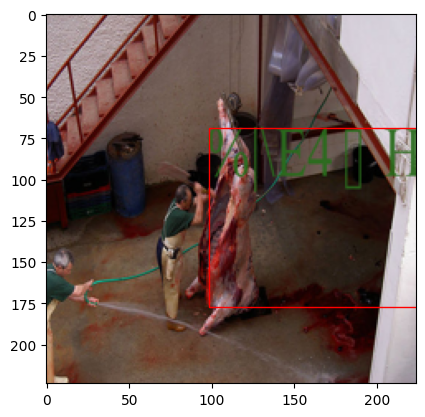

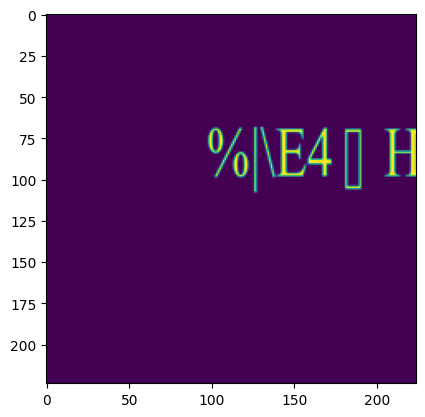

In [406]:
import matplotlib.patches as patches

k = 50
# draw one example
fig, ax = plt.subplots(1)
ax.imshow(X_data_watermarked[k])
for bbox in y_data_bbox[k]:
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

# plot the ground truth
fig, ax = plt.subplots(1)
ax.imshow(y_data_watermarked[k])
plt.show()

In [407]:
# save the data
np.save(os.path.join("data", "dataset", "X_data_watermarked.npy"), X_data_watermarked)
np.save(os.path.join("data", "dataset", "y_data_watermarked.npy"), y_data_watermarked)